In [1]:
!pip install -U accelerate peft transformers einops datasets bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.16.1
    Uninstalling datasets-2.16.1:
      Successfully uninstalled datasets-2.16.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1


In [2]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.27.0
bitsandbytes==0.42.0
datasets==2.17.0
einops==0.7.0
peft==0.8.2
torch==2.0.0
transformers==4.37.2


## Set a seed for reproducibility of the training process

In [3]:
from transformers import set_seed

set_seed(42)

2024-02-13 08:45:21.339622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 08:45:21.369941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 08:45:21.369971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 08:45:21.370765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 08:45:21.376650: I tensorflow/core/platform/cpu_feature_guar

# Load model and tokenizer

## Load model in 4 bit

In [4]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",          
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

## Load tokenizer

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
len(tokenizer)

50295

## Add ChatML tokens to tokenizer

In [8]:
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings. 

In [9]:
model.model.embed_tokens

Embedding(51200, 2560)

## Prepare LoRA adapters

In [10]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) 

lora_config = LoraConfig(
    r=32, 
    lora_alpha=32, 
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

# Load and preprocess dataset

In [11]:
from datasets import load_dataset

dataset = load_dataset("Rajesh222/mistral_riddles_synthetic_data")
dataset = dataset["train"].train_test_split(test_size=0.1)

Generating train split:   0%|          | 0/1655 [00:00<?, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 1489
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 166
    })
})

In [13]:
dataset["train"][0]

{'number': 1358,
 'messages': ['What is hard as a rock and heavy as lead but can be carried by a child?',
  'The answer to this riddle is a nut. While a nut is hard like a rock and heavy compared to its size, a child can still carry a handful of them.',
  "Wow, that's a neat riddle! What could be soft inside but hard outside and could be easily carried by little hands?",
  'The answer to this riddle is a walnut. A walnut is soft and edible on the inside, but its hard, protective shell is hard and can be easily carried by little hands.']}

## Apply ChatML format and tokenize

In [17]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []
    for i, msg in enumerate(input['messages']):
        isHuman = i%2 ==0
        msg_chatml = templates[isHuman].format(msg=msg)
        msg_tokenized = tokenizer(msg_chatml, truncation=False, add_special_tokens=False)
        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024), # max sample length 1024 tokens, enough for this dataset
    batched=False, 
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)
        

Map (num_proc=72):   0%|          | 0/1489 [00:00<?, ? examples/s]

Map (num_proc=72):   0%|          | 0/166 [00:00<?, ? examples/s]

longest sample: 1024 tokens


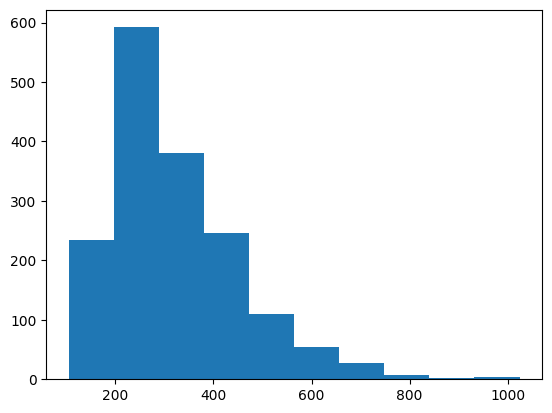

In [18]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()

## Define a collate function, train on answers only

In [19]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )   
        labels.extend( pad_len * [IGNORE_INDEX] )    
        attention_mask.extend( pad_len * [0] ) 

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

# Train

## Set hyperparameters

In [20]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=1     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=0.00002  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

In [22]:
!pip3 install wandb

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.3 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 11.9 MB/s eta 0:00:00
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
Using cached smmap-5.0.1-py3-none-any.whl (24 kB)


In [23]:
# log to a specific wandb project
import wandb 
run = wandb.init(
    project="phi2",
    name="testrun",
)

wandb: Currently logged in as: rajeshthakur1r. Use `wandb login --relogin` to force relogin


In [25]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [26]:
trainer.train()

Step,Training Loss,Validation Loss
46,1.469200,1.482609
92,1.440600,1.354509
138,1.368600,1.240165
184,1.206300,1.170893
230,1.066300,1.152811
276,1.130600,1.142472
322,1.093600,1.135847
368,1.033600,1.134064
414,1.068800,1.135855
460,1.049800,1.130032


TrainOutput(global_step=1860, training_loss=0.9063519478805604, metrics={'train_runtime': 6408.4613, 'train_samples_per_second': 4.647, 'train_steps_per_second': 0.29, 'total_flos': 1.5958334115704832e+17, 'train_loss': 0.9063519478805604, 'epoch': 19.99})

# After training: Merge LoRA adapters with base model

In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="out/checkpoint-1860" 

# where to save merged model
save_to="trained_model"       

# Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="trained_model"    
question="What is hard as a rock and heavy as lead but can be carried by a child?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

loading configuration file trained_model/config.json
Model config PhiConfig {
  "_name_or_path": "trained_model",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-2--configuration_phi.PhiConfig",
    "AutoModelForCausalLM": "microsoft/phi-2--modeling_phi.PhiForCausalLM"
  },
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50297,
  "hidden_act": "gelu_new",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "partial_rotary_factor": 0.4,
  "qk_layernorm": false,
  "resid_pdrop": 0.1,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 51200
}

loading weights file traine

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing PhiForCausalLM.

All the weights of PhiForCausalLM were initialized from the model checkpoint at trained_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PhiForCausalLM for predictions without further training.
loading configuration file trained_model/generation_config.json
Generate config GenerationConfig {
  "do_sample": true,
  "eos_token_id": 50297,
  "max_new_tokens": 100,
  "pad_token_id": 50296,
  "repetition_penalty": 1.18,
  "temperature": 0.7,
  "top_k": 40,
  "top_p": 0.1
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The answer to the riddle is "a stone." A stone is hard like a rock, heavy compared to most objects that can be easily carried by a child. If you have any questions about what type of stones are typically described in this context or if there's anything else I can help with, please let me know!


In [34]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model_path = "trained_model"  # Ensure that this path points to your trained model
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Check if model and tokenizer are loaded successfully
if model is None:
    raise ValueError("Failed to load the model.")
if tokenizer is None:
    raise ValueError("Failed to load the tokenizer.")

# Push model and tokenizer to the Hugging Face Hub
model.push_to_hub("Rajesh222/phi-2_riddles-evolved")
tokenizer.push_to_hub("Rajesh222/phi-2_riddles-evolved")

loading configuration file trained_model/config.json
Model config PhiConfig {
  "_name_or_path": "trained_model",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-2--configuration_phi.PhiConfig",
    "AutoModelForCausalLM": "microsoft/phi-2--modeling_phi.PhiForCausalLM"
  },
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50297,
  "hidden_act": "gelu_new",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "partial_rotary_factor": 0.4,
  "qk_layernorm": false,
  "resid_pdrop": 0.1,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 51200
}

loading weights file traine

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing PhiForCausalLM.

All the weights of PhiForCausalLM were initialized from the model checkpoint at trained_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PhiForCausalLM for predictions without further training.
loading configuration file trained_model/generation_config.json
Generate config GenerationConfig {
  "do_sample": true,
  "eos_token_id": 50297,
  "max_new_tokens": 100,
  "pad_token_id": 50296,
  "repetition_penalty": 1.18,
  "temperature": 0.7,
  "top_k": 40,
  "top_p": 0.1
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Configuration saved in /tmp/tmp5rsfyz4p/config.json
Configuration saved in /tmp/tmp5rsfyz4p/gener

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer config file saved in /tmp/tmpozyivvav/tokenizer_config.json
Special tokens file saved in /tmp/tmpozyivvav/special_tokens_map.json
Uploading the following files to Rajesh222/phi-2_riddles-evolved: added_tokens.json,tokenizer_config.json,README.md,tokenizer.json,merges.txt,vocab.json,special_tokens_map.json


CommitInfo(commit_url='https://huggingface.co/Rajesh222/phi-2_riddles-evolved/commit/5cc31fce6cc7ebbfbc168a9895c4d126f78a6b63', commit_message='Upload tokenizer', commit_description='', oid='5cc31fce6cc7ebbfbc168a9895c4d126f78a6b63', pr_url=None, pr_revision=None, pr_num=None)